In [ ]:
!pip install triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 5.6 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade triton

Epoch: 1, Loss: 1.2082, Accuracy: 88.67%


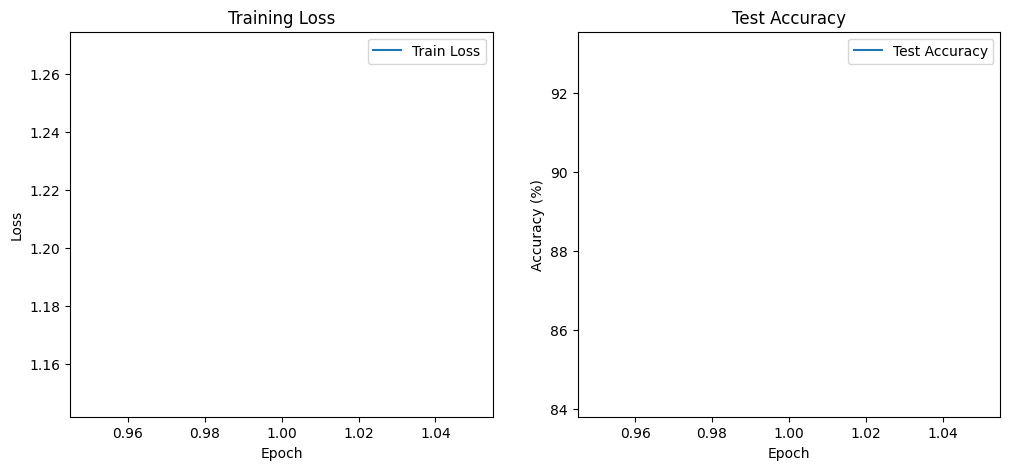

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define the neural network model using PyTorch modules
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
        self.relu2 = nn.ReLU()

        # Calculate the size of the flattened features after convolutions
        self.flattened_size = self._get_flattened_size()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def _get_flattened_size(self):
        # Create a dummy input to calculate the size after convolutions
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)
            x = self.conv1(x)
            x = self.relu1(x)
            x = self.conv2(x)
            x = self.relu2(x)
            flattened_size = x.numel()
        return flattened_size

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Data Loading and Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True,
                               transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False,
                              transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1000,
                         shuffle=False, num_workers=2)

# Initialize the model, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Training Parameters
num_epochs = 1  # Run for 1 epoch as requested
train_losses, test_accuracies = [], []

# Training and Evaluation Loop
for epoch in range(num_epochs):
    # Training
    model.train()
    epoch_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Evaluation
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracies.append(accuracy)
    print(f'Epoch: {epoch + 1}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%')

# Plot Loss and Accuracy
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy")
plt.legend()

plt.show()


Epoch: 1, Loss: 3146.0347, Accuracy: 70.15%


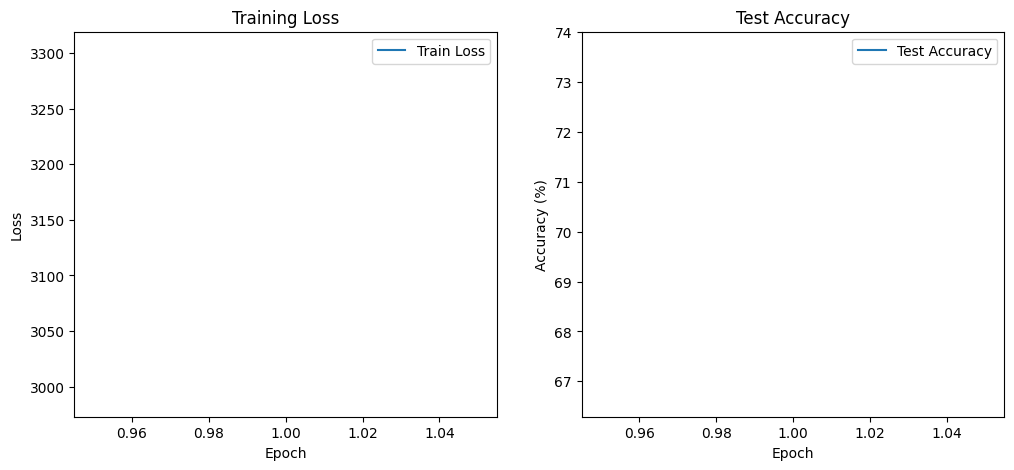

In [ ]:
import torch
import triton
import triton.language as tl
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Triton kernel for ReLU activation
@triton.jit
def relu_kernel(x_ptr, y_ptr, N,
                BLOCK_SIZE: tl.constexpr):
    idx = tl.program_id(0) * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    mask = idx < N
    x = tl.load(x_ptr + idx, mask=mask)
    y = tl.where(x > 0, x, 0)
    tl.store(y_ptr + idx, y, mask=mask)

def triton_relu(x):
    y = torch.empty_like(x)
    N = x.numel()
    BLOCK_SIZE = 1024
    grid = ((N + BLOCK_SIZE - 1) // BLOCK_SIZE,)
    relu_kernel[grid](x, y, N, BLOCK_SIZE=BLOCK_SIZE)
    return y

# Triton kernel for 2D convolution
@triton.jit
def conv2d_kernel(
    input_ptr, weight_ptr, output_ptr,
    H, W, KH, KW, OH, OW,
    stride_h, stride_w, padding_h, padding_w,
    c_out: tl.constexpr,  # Output channel to process
    C_in: tl.constexpr,
    BLOCK_H: tl.constexpr, BLOCK_W: tl.constexpr
):
    # Compute block indices
    pid_h = tl.program_id(0)
    pid_w = tl.program_id(1)

    # Compute output indices for the block
    h_out = pid_h * BLOCK_H + tl.arange(0, BLOCK_H)
    w_out = pid_w * BLOCK_W + tl.arange(0, BLOCK_W)

    # Expand dimensions for broadcasting
    h_out = h_out[:, None]  # (BLOCK_H, 1)
    w_out = w_out[None, :]  # (1, BLOCK_W)
    mask = (h_out < OH) & (w_out < OW)

    # Initialize accumulation tensor
    acc = tl.zeros((BLOCK_H, BLOCK_W), dtype=tl.float32)

    # Loop over input channels and kernel dimensions
    for c_in in range(C_in):
        for kh in range(KH):
            for kw in range(KW):
                h_in = h_out * stride_h - padding_h + kh
                w_in = w_out * stride_w - padding_w + kw

                # Check for valid input indices
                mask_in = (h_in >= 0) & (h_in < H) & (w_in >= 0) & (w_in < W) & mask

                # Compute input and weight pointers
                in_ptrs = input_ptr + c_in * H * W + h_in * W + w_in
                w_ptrs = weight_ptr + c_out * C_in * KH * KW + c_in * KH * KW + kh * KW + kw

                # Load input and weights
                in_vals = tl.load(in_ptrs, mask=mask_in, other=0.0)
                w_val = tl.load(w_ptrs)

                # Accumulate
                acc += in_vals * w_val

    # Store the result
    out_ptrs = output_ptr + c_out * OH * OW + h_out * OW + w_out
    tl.store(out_ptrs, acc, mask=mask)

def triton_conv2d(x, weight, stride=(1, 1), padding=(0, 0)):
    B, C_in, H, W = x.shape
    C_out, _, KH, KW = weight.shape
    stride_h, stride_w = stride
    padding_h, padding_w = padding

    # Compute output dimensions
    OH = (H + 2 * padding_h - KH) // stride_h + 1
    OW = (W + 2 * padding_w - KW) // stride_w + 1

    output = torch.empty((B, C_out, OH, OW), dtype=torch.float32, device=x.device)

    BLOCK_H = 8
    BLOCK_W = 8
    grid = (
        (OH + BLOCK_H - 1) // BLOCK_H,
        (OW + BLOCK_W - 1) // BLOCK_W,
    )

    for b in range(B):
        input_ptr = x[b].contiguous().view(-1)
        output_ptr = output[b].contiguous().view(-1)
        for c_out in range(C_out):
            conv2d_kernel[grid](
                input_ptr,
                weight.view(-1),
                output_ptr,
                H, W, KH, KW, OH, OW,
                stride_h, stride_w, padding_h, padding_w,
                c_out=c_out,
                C_in=C_in,
                BLOCK_H=BLOCK_H, BLOCK_W=BLOCK_W
            )
    return output

# Using PyTorch's matmul for linear layers
def triton_linear(x, weight, bias):
    output = x @ weight + bias
    return output

# Model forward pass using Triton kernels
def forward_pass(x, conv1_weight, conv2_weight, fc1_weight, fc1_bias, fc2_weight, fc2_bias):
    x = triton_conv2d(x, conv1_weight, stride=(1, 1), padding=(0, 0))
    x = triton_relu(x)
    x = triton_conv2d(x, conv2_weight, stride=(1, 1), padding=(0, 0))
    x = triton_relu(x)
    x = x.view(x.shape[0], -1)  # Flatten
    x = triton_linear(x, fc1_weight, fc1_bias)
    x = triton_relu(x)
    x = triton_linear(x, fc2_weight, fc2_bias)
    return x

# Data Loading and Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True,
                               transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False,
                              transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1000,
                         shuffle=False, num_workers=2)

# Initialize weights for the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv1_weight = torch.randn((16, 1, 3, 3), dtype=torch.float32, device=device, requires_grad=True)
conv2_weight = torch.randn((32, 16, 3, 3), dtype=torch.float32, device=device, requires_grad=True)

# Calculate the flattened size after convolutions
H_after_conv1 = (28 - 3 + 0 * 2) // 1 + 1  # 26
H_after_conv2 = (H_after_conv1 - 3 + 0 * 2) // 1 + 1  # 24
flattened_size = H_after_conv2 * H_after_conv2 * 32  # 24 * 24 * 32

fc1_weight = torch.randn((flattened_size, 128), dtype=torch.float32, device=device, requires_grad=True)
fc1_bias = torch.randn((128,), dtype=torch.float32, device=device, requires_grad=True)
fc2_weight = torch.randn((128, 10), dtype=torch.float32, device=device, requires_grad=True)
fc2_bias = torch.randn((10,), dtype=torch.float32, device=device, requires_grad=True)

# Training Parameters
num_epochs = 1  # Run for 1 epoch as requested
learning_rate = 0.001
optimizer = torch.optim.SGD([conv1_weight, conv2_weight, fc1_weight, fc1_bias, fc2_weight, fc2_bias], lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses, test_accuracies = [], []

# Training and Evaluation Loop
for epoch in range(num_epochs):
    # Training
    epoch_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        data = data.float()
        # Forward pass using Triton kernels
        output = forward_pass(data, conv1_weight, conv2_weight, fc1_weight, fc1_bias, fc2_weight, fc2_bias)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Evaluation
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.float()
            output = forward_pass(data, conv1_weight, conv2_weight, fc1_weight, fc1_bias, fc2_weight, fc2_bias)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracies.append(accuracy)
    print(f'Epoch: {epoch + 1}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%')

# Plot Loss and Accuracy
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy")
plt.legend()

plt.show()
